In [95]:
#code by Abhay Pratap Singh
# generate pseduo label images using set of images 
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import copy
from numpy.random import choice

In [96]:
# generate  j[0] scale with all chanels = R = G = B = grayscale
# Y = 0.2125 R + 0.7154 G + 0.0721 B
# These weights are used by CRT phosphors as they better represent human perception of red, green and blue than equal weights.
# http://www.poynton.com/PDFs/ColorFAQ.pdf
# take img a input
def GrayScalePL(image):
    img = copy.deepcopy(image)
    grayscale = rgb2gray(img)
    return np.stack((grayscale,)*3, axis=-1)


In [97]:
# generate patched images for pseudo labels (eg: image inpainting)
# patches can be made on individual channels
# patch shape is square by default
# patch can either be 0-100% area of the img
# take image, patch size percentage, which channels to use, fill value,degree*
# *not yet implemented
def RandomPatchPL(original, patch_size=10, channels="RGB", fill_value=255):
    img = copy.deepcopy(original)
    N, M, _ = img.shape
    d = int((np.sqrt(patch_size*N*M)/10))

    # N-1 - x + 1 = d
    row_limit = N-d
    col_limit = M-d
    tl = np.random.randint(low=0, high=row_limit+1, size=1)[0]
    tr = np.random.randint(low=0, high=col_limit+1, size=1)[0]
    # channels = "RGB", "R" etc
    R, G, B = 1, 1, 1
    if len(channels) != 0:
        R, G, B = 0, 0, 0
        if (channels.find('R') != -1):
            R = 1
        if (channels.find('G') != -1):
            G = 1
        if (channels.find('B') != -1):
            B = 1
    if (R == 1):
        img[tl:tl+d, tr:tr+d, 0] = fill_value
    if (G == 1):
        img[tl:tl+d, tr:tr+d, 1] = fill_value
    if (B == 1):
        img[tl:tl+d, tr:tr+d, 2] = fill_value
    return img


In [98]:
# generate low resolution images for training data
# image is downscaled and upscaled to same size to reduce resolution
# parameter scale is used to downsample
def SuperResolutionPL(image, scale=0.1):
    img = copy.deepcopy(image)
    N, M, _ = img.shape
    downscaled_img = rescale(img, scale, anti_aliasing=True, multichannel=True)
    upscaled_img = resize(downscaled_img, (N, M), anti_aliasing=False)
    return upscaled_img


In [99]:
# return same image
def RealImagePL(image):
    return image


In [113]:
# randomly select the pretext task and convert
# user will pass what pretext task are requred
def RandomPretextConverter(data, tasks):
    return np.array(list(map(lambda image : choice(tasks)(image), data)))


(1080, 1920, 3)


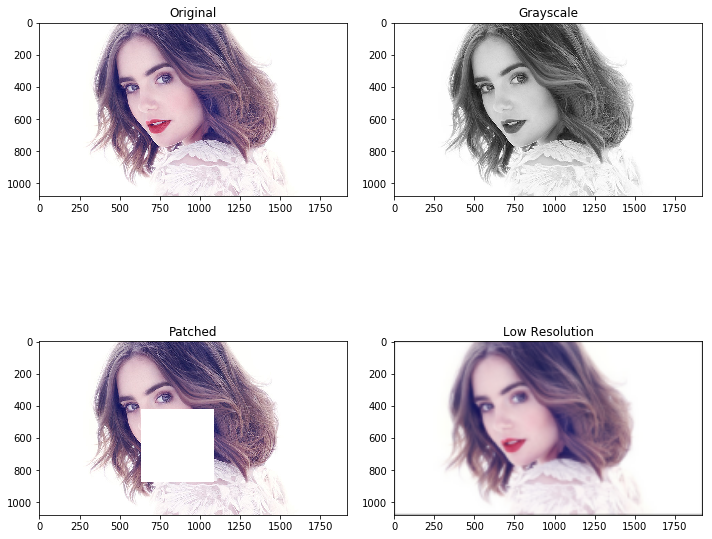

In [114]:
original = imread('4.jpg')
print(original.shape)
grayscale = GrayScalePL(original)
patched = RandomPatchPL(original)
low_res = SuperResolutionPL(original)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(grayscale, cmap=plt.cm.gray)
ax[1].set_title("Grayscale")
ax[2].imshow(patched)
ax[2].set_title("Patched")
ax[3].imshow(low_res)
ax[3].set_title("Low Resolution")

fig.tight_layout()
plt.show()

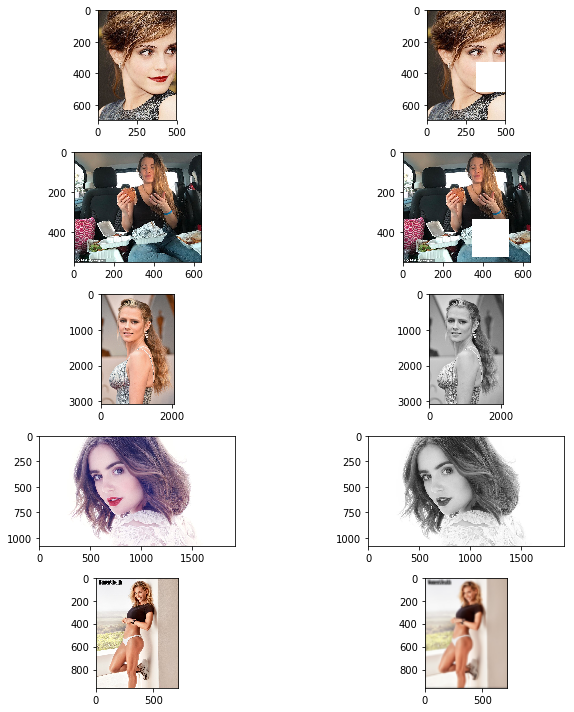

In [115]:
data = []
data.append(imread('1.jpeg'))
data.append(imread('2.jpg'))
data.append(imread('3.jpeg'))
data.append(imread('4.jpg'))
data.append(imread('5.jpg'))

output = RandomPretextConverter(np.array(data), tasks=[
    GrayScalePL,
    RandomPatchPL,
    SuperResolutionPL,
    RealImagePL
])

fig, axes = plt.subplots(5, 2, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(data[0])
ax[1].imshow(output[0])

ax[2].imshow(data[1])
ax[3].imshow(output[1])

ax[4].imshow(data[2])
ax[5].imshow(output[2])

ax[6].imshow(data[3])
ax[7].imshow(output[3])

ax[8].imshow(data[4])
ax[9].imshow(output[4])


fig.tight_layout()
plt.show()

In [103]:
import torch
import torchvision
import torchvision.transforms as transforms

In [104]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


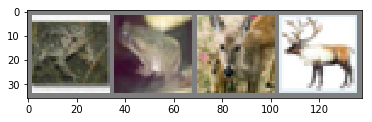

 frog  frog  deer  deer


In [121]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [129]:
print(type(images))
print(images.shape)
img = np.transpose(images.numpy(), (0,2,3,1))
print(type(img))
print(img.shape)
out = np.transpose(img, (0,3,1,2))
out = torch.from_numpy(out).float()
print(type(out))
print(out.shape)

<class 'torch.Tensor'>
torch.Size([4, 3, 32, 32])
<class 'numpy.ndarray'>
(4, 32, 32, 3)
<class 'torch.Tensor'>
torch.Size([4, 3, 32, 32])


In [130]:
# randomly select the pretext task and convert
# user will pass what pretext task are requred
def RandomPretextConverter(data, tasks):
    # convert data torch tensor to numpy image
    data = np.transpose(data.numpy(), (0, 2, 3, 1))
    out = map(lambda image: choice(tasks)(image), data)
    out = np.array(list(out))
    # return torch tensor of appropriate shae
    out = np.transpose(out, (0, 3, 1, 2))
    return torch.from_numpy(out).float()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


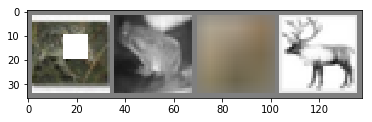

In [136]:
output = RandomPretextConverter(images, tasks=[
    GrayScalePL,
    RandomPatchPL,
    SuperResolutionPL
])
imshow(torchvision.utils.make_grid(output))